## Objetivo

O objetivo deste notebook é de utilizar alguns métodos de regressão para poder prever as informações desejadas através dos dados passados, para isso, é realizada uma série de testes e tentativas relacionadas à esses métodos com o intuito de observar os melhores resultados.

## Importação de bibliotecas e leitura dos dados

Para iniciar esta etapa do projeto, é necessário importar uma série de bibliotecas e métodos específicos dessas bibliotecas a fim de facilitar a realização das regressões.

In [46]:
# biblioteca encarregada de fazer operações e analisar informações de arquivos .json
import json

# pandas para criação de DataFrames e estruturação dos dados
import pandas as pd

# numpy para facilitar o tratamento e manutenção dos dados
import numpy as np

# pyplot (módulo da biblioteca matplotlib) para criação e renderização dos gráficos
import matplotlib.pyplot as plt

# função que retorna o tipo de uma variável presentes em um dataset
from pandas.api.types import is_numeric_dtype

# módulo de criação de Pipelines da biblioteca sklearn
from sklearn.pipeline import Pipeline

# módulo capaz de gerar interações de features polinomiais
from sklearn.preprocessing import PolynomialFeatures

# módulo de regressão linear
from sklearn.linear_model import LinearRegression

# módulo de divisão entre dados de treino e teste
from sklearn.model_selection import train_test_split

# módulo do regressor dummy (regressor que retorna apenas a média dos valores) para servir como base de comparação
from sklearn.dummy import DummyRegressor

# função para medir o erro quadrático médio
from sklearn.metrics import mean_squared_error

# módulo do regressor de k-vizinhos
from sklearn.neighbors import KNeighborsRegressor

# função para fazer um produto dentro de loops
from itertools import product

# modelos de regressão e classificação de árvore de decisão
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# visualização de árvores
from sklearn import tree

# visualização de árvores em texto
from sklearn.tree import export_text

# floresta aleatória
from sklearn.ensemble import RandomForestRegressor as RFR

# importância de permutação
from sklearn.inspection import permutation_importance

Com as bibliotecas necessárias importadas, podemos definir algumas variáveis utilizadas através do código e importar os dados a serem utilizados para um DataFrame.

In [2]:
# Semente definida para operações com aleatoridade para manter a repetibilidade do trabalho
seed = 97404

# Setando a seed da biblioteca numpy para a semente anteriormente definida
np.random.seed(seed)

# Leitura dos dados utilizados e definição do DataFrame principal
df = pd.read_csv("Final Data.csv", index_col="Unnamed: 0")

## Início das regressões

Após setar as variáveis e definir o DataFrame principal, iniciamos os processos de regrssão. O primeiro modelo de regrssão que iremos explorar e estudar é o modelo de regressão polinomial. Para começar, são feitas 3 regressões diferentes com os graus de polinômio 1, 6 e 15 respectivamente.

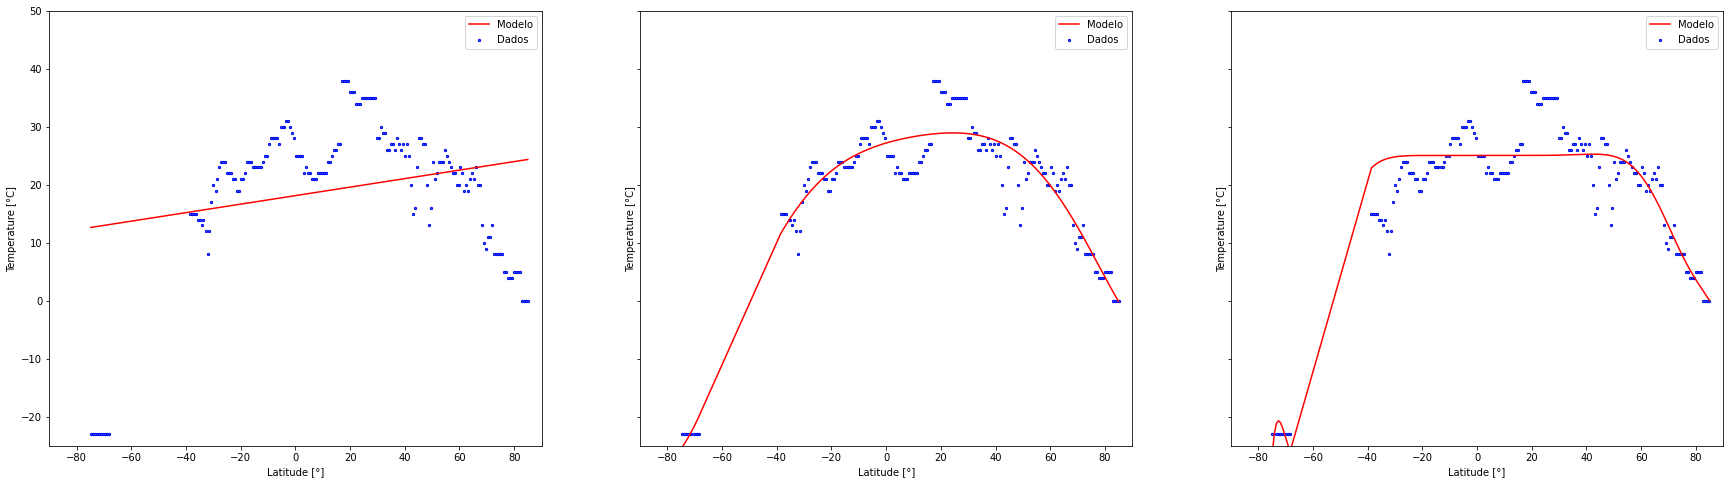

In [3]:
# Definindo o grau de complexidade dos modelos polinomiais
COMPLEXIDADE_DOS_MODELOS = [1, 6, 15]

# Obtenção da figura e do eixo de plots do pyplot para os gráficos
fig, axes = plt.subplots(
    ncols=len(COMPLEXIDADE_DOS_MODELOS),
    nrows=1,
    figsize=(len(COMPLEXIDADE_DOS_MODELOS) * 10, 8),
    sharey=True,
)


for i in range(len(COMPLEXIDADE_DOS_MODELOS)):
    eixo = axes[i]

    # Este bloco cria o pipeline do modelo que será ajustado
    polynomial_features = PolynomialFeatures(
        degree=COMPLEXIDADE_DOS_MODELOS[i], include_bias=False
    )
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("features_polinomiais", polynomial_features),
            ("regressao_linear", linear_regression),
        ]
    )
    pipeline.fit(df["latitude"].values[:, np.newaxis], df["temperature"].values)

    # Plotando!
    eixo.plot(
        df["latitude"],
        pipeline.predict(df["latitude"].values[:, np.newaxis]),
        label="Modelo",
        color="r",
    )
    eixo.scatter(df["latitude"].values, df["temperature"].values, edgecolor="b", s=5, label="Dados")

    # Configurando o plot
    eixo.set_xlabel("Latitude [°]")
    eixo.set_ylabel("Temperature [°C]")
    eixo.set_xlim((-90, 90))
    eixo.set_ylim((-25, 50))
    eixo.legend()

plt.show()

É possível observar os diferentes resultados obtidos, em especial o modelo utilizando um polinômio de grau 6 (meio), que apesar de não retornar resultados precisos é o modelo que mais se adequou aos dados fornecidos, enquanto que o modelo com grau 1 (linha - esquerda) sofreu um underfiting e não representa bem os valores passados e o com grau 15 (direita) sofreu um overfitting dos dados e resulta em informações errôneas, principalmente nas regiões dos extremos.

## Preparação do DataFrame para regressões numéricas

Os próximos modelos a serem testados necessitam de dados numéricos e como nosso DataFrame possui dados não numéricos, precisamos primeiramente converter os tipos de valores dos dados para tipos mais desejaveis, e após isso, remover os dados não numéricos completamente.

In [4]:
df.dtypes

latitude                float64
wind_speed                int64
wind_degree               int64
pressure                  int64
precip                  float64
humidity                  int64
cloudcover                int64
uv_index                  int64
visibility                int64
is_day                     bool
temperature               int64
weather_descriptions     object
feelslike                 int64
dtype: object

In [5]:
df = df.convert_dtypes()

In [6]:
df.dtypes

latitude                Float64
wind_speed                Int64
wind_degree               Int64
pressure                  Int64
precip                  Float64
humidity                  Int64
cloudcover                Int64
uv_index                  Int64
visibility                Int64
is_day                  boolean
temperature               Int64
weather_descriptions     string
feelslike                 Int64
dtype: object

Como podemos observar pelos tipos de dados, alguns deles foram alterados, sempre preferindo dados mais faceis de se utilizar.

A próxima etapa é remover os dados não numéricos, para isso, é feita uma função que verificará cada um dos dados e removerá aqueles que não são numericos, retornando ao final um DataFrame novo apenas com números 

In [7]:
def remove_not_numbers(df):
    df_c = df.copy()
    for i in df_c.columns:
        if is_numeric_dtype(df_c[i]) == False or str(df_c[i].dtype) == 'boolean':
            #print(i, "removido")
            df_c = df_c.drop([i], axis=1)
        else:
            continue
    return df_c

In [8]:
df_num = remove_not_numbers(df)

Utilizando o código acima, podemos remover os dados indesejados do DataFrame, tratando-o e passando para a próxima etapa, que consiste em dividir os dados em teste e treino

## Divisão dos dados em teste e treino

Para dividir os dados, foi utilizada a função `train_test_split` para separa-los de maneira aleatória (utilizando a seed passada) com o intuito de reservar parte dos dados para teste sem ser utilizado para o treino

In [9]:
test_size = 0.2
FEATURES = ["latitude", "wind_speed", "wind_degree", "pressure", "precip", "humidity", "cloudcover", "uv_index", "visibility"]
TARGET = ["temperature", "feelslike"]

indices = df_num.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=test_size, random_state=seed
)

df_treino = df_num.loc[indices_treino]
df_teste = df_num.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
x_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
x_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

Com isso feito, podemos criar agora um modelo baseline, este servirá como comparação para modelo futuros, sendo possível compara-lo para ter uma quantização da melhoria ou piora dos modelos testados

## Modelo Baseline

Como boa conduta, podemos criar um modelo base para comparar nossos outros modelos com este para saber a melhoria de tal modelo em relação ao baseline. Para isso, podemos utilizar o método `DummyRegressor` do sklearn para cria-lo.

In [10]:
# cria o modelo
modelo_baseline = DummyRegressor()

# treina o modelo
modelo_baseline.fit(x_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_baseline.predict(x_teste)

Com o modelo pronto e fitado para os dados, podemos seguir para a previsão desses

In [11]:
y_verdadeiro = y_teste
y_previsao = modelo_baseline.predict(x_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo baseline foi de {RMSE}.")

O RMSE do modelo baseline foi de 16.475517267941274.


Como é possível observar, erro quadrático médio (RMSE - utilizado para testar a eficácia de um modelo em prever dados) foi de aproximadamente 16.47 °C, ou seja, o modelo baseline retorna em média um valor com margem de erro de 16.47 °C quando prevendo a temperatura para aqueles dados. Já que o modelo baseline é apenas um comparativo e sempre retornará o valor médio dos dados, era esperado esse resultado.

## Modelo Linear

Agora com um modelo baseline e um método de medir a eficácia de modelos, podemos começar a comparar diferentes métodos, começando com o modelo mais simples (sem ser o baseline) o modelo linear. Para tal, foi utilizada o método `LinearRegression` para criar o modelo e foi feito o fit de tal modelo. Após isso podemos fazer a previsão de dados a fim de testar sua eficácia.

In [12]:
# cria o modelo
modelo_linear = LinearRegression()

# treina o modelo
modelo_linear.fit(x_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_linear.predict(x_teste)
print(previsao)

[[ 20.59247304  20.64173266]
 [ 19.95622531  18.51310471]
 [ 18.13748559  17.64988382]
 [ 28.9741433   29.33304496]
 [ 22.6064601   24.41296281]
 [ 26.82314607  27.66342128]
 [ 23.09434745  21.30102605]
 [ 13.34392318  12.54435142]
 [ 38.15618576  38.50338344]
 [ 23.06411099  21.26834221]
 [ 23.13723655  21.93875321]
 [  0.55404336  -6.49964403]
 [ 22.44013819  20.51740098]
 [ 23.45455605  23.02313385]
 [ 21.14022976  22.6169237 ]
 [ 27.21481748  28.49236942]
 [  6.69764529   3.47138436]
 [ 15.53255533  14.51089074]
 [  6.0192049    2.40983212]
 [ 23.96361715  22.80630698]
 [ -3.74617247 -12.39149538]
 [ 14.41788127  15.06771392]
 [ 12.04552034  11.2071945 ]
 [ 38.09654125  38.4389112 ]
 [ -3.68404276 -12.3243368 ]
 [  6.757704     3.53630432]
 [ 14.24918146  15.29584016]
 [ 25.82732517  25.92161002]
 [ -3.6550489  -12.29299612]
 [ 19.82553757  18.87459453]
 [ 34.50414601  35.47618702]
 [ 12.94787673  11.23996029]
 [ 22.1076013   22.64308715]
 [ 22.8902495   22.14622298]
 [ 23.17098194

Aqui podemos observar as previsões feitas para cada um dos conjuntos de dados passados para o modelo.

In [13]:
y_verdadeiro = y_teste
y_previsao = modelo_linear.predict(x_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo linear foi de {RMSE}.")

O RMSE do modelo linear foi de 8.255970938353956.


Finalmente chegamos no comparativo entre este modelo e o baseline. É possível observar que o RMSE do modelo linear foi de 8.25 °C, quase metade do valor obtido pelo modelo baseline. Podemos concluir que apesar de ter ainda um erro muito grande nas suas previsões, o modelo linear atingiu uma acurácia bem maior, mas ainda é possível melhorar

## K-vizinhos mais próximos

O próximo modelo a ser estudado é o modelo de K-vizinhos mais próximos, nesse modelo, as previsões são feitas a partir da vizinhaça do ponto em que estamos tentando prever o resultado. Mas antes de começar a fazer o modelo e prever os dados, precisamos normalizar o nosso DataFrame, isso é preferível pois ajuda o modelo com dados que possuem anormalidades ou até mesmo uma amplitude muito grande dentro de seus extremos.

In [14]:
#Normalize function
def normalize(df):
    df_c = df.copy()
    for index in df_c.columns:
        i = index
        if is_numeric_dtype(df_c[i]) == False or str(df_c[i].dtype) == 'boolean':
            df_c[index] = df_c[index]
        else:
            df_c[i] = df_c[i] / df_c[i].max()
    return df_c

Feita uma função de normalização de dados dentro do dataframe, podemos normalizar os dados e começar a montar o modelo

In [15]:
df = normalize(df_num)

Primeiramente, nos separamos novamente os dados em treino e teste, porém desta vez eles estarão normalizados

In [16]:
indices = df.index
indices_training, indices_test = train_test_split(indices, test_size = test_size, random_state = seed)

df_training = df.loc[indices_training]
df_test = df.loc[indices_test]

x_training = df_training.reindex(FEATURES, axis = 1).values
y_training = df_training.reindex(["temperature"], axis = 1).values
x_test = df_test.reindex(FEATURES, axis = 1).values
y_test = df_test.reindex(["temperature"], axis = 1).values

In [17]:
df_training

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
13,0.948905,0.54902,0.304469,0.991194,0.0,0.8,0.37,0.111111,1.0,0.131579,0.026316
156,-0.267247,0.27451,0.044693,0.994129,0.0,0.09,0.0,0.111111,1.0,0.552632,0.552632
153,-0.242524,0.254902,0.075419,0.995108,0.0,0.1,0.0,0.111111,1.0,0.5,0.5
223,-0.838239,0.588235,0.337989,0.980431,0.0,0.6,0.46,0.111111,1.0,-0.605263,-0.947368
41,0.710619,0.392157,0.418994,0.990215,0.022222,0.73,0.0,0.555556,1.0,0.605263,0.657895
...,...,...,...,...,...,...,...,...,...,...,...
105,0.166,0.254902,0.583799,0.988258,0.007407,0.76,0.51,0.666667,1.0,0.684211,0.736842
163,-0.32729,0.294118,0.863128,0.990215,0.0,0.14,0.0,0.111111,1.0,0.605263,0.578947
37,0.744643,0.352941,0.48324,0.990215,0.059259,0.89,0.73,0.444444,0.9,0.5,0.5
173,-0.412056,0.686275,0.756983,0.990215,0.0,0.75,0.1,0.111111,1.0,0.368421,0.315789


In [18]:
df_test

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
27,0.829762,0.098039,0.681564,0.98728,0.044444,1.0,1.0,0.333333,0.2,0.289474,0.289474
166,-0.35319,0.372549,0.787709,0.992172,0.0,0.19,0.0,0.111111,1.0,0.526316,0.526316
29,0.812809,0.078431,0.340782,0.986301,0.0,0.86,0.48,0.333333,1.0,0.263158,0.263158
49,0.642571,0.27451,0.382682,0.988258,0.0,0.48,0.22,0.777778,1.0,0.684211,0.684211
39,0.72769,0.215686,0.441341,0.992172,0.088889,0.85,0.76,0.444444,0.9,0.5,0.5
50,0.634095,0.215686,0.343575,0.989237,0.0,0.6,0.36,0.666667,1.0,0.631579,0.657895
136,-0.097834,0.176471,0.949721,0.986301,0.0,0.19,0.0,0.111111,1.0,0.736842,0.684211
172,-0.403814,0.078431,0.243017,0.990215,0.0,0.71,0.03,0.111111,1.0,0.342105,0.342105
99,0.216977,0.196078,0.469274,0.984344,0.0,0.13,0.07,1.0,1.0,1.0,1.0
137,-0.106428,0.176471,0.949721,0.986301,0.0,0.19,0.0,0.111111,1.0,0.736842,0.684211


É possível ver pelos dados acima que o DataFrame foi normalizado e separado com sucesso

## Hiperparâmetros.

O conceito de hiperparâmetro, para Machine Learning, é um parâmetro utilizado para controlar o aprendizado em si. Em outro sentido, são derivados valores por meio de treinamento. Assim, ele permite controlar o processo de treinamento do modelo.

Com este conceito em mente, podemos começar a explorar os modelos de regressão que possuem hiperparâmetros que podem ser alterados com o intuito de melhorar a acurácia de tal modelo. Em princípio, vamos pegar o modelo de K-vizinhos para estudar, tendo como principal hiperparâmetro o número de vizinhos a ser considerado.

In [19]:
num_neighbors = [2, 4, 6, 20, 40, 60]

for n in num_neighbors:
    modelo_de_knn = KNeighborsRegressor(n_neighbors=n)
    
    modelo_de_knn.fit(x_training, y_training)
    
    y_previsao = modelo_de_knn.predict(x_test)
    RMSE = mean_squared_error(y_test, y_previsao, squared=False)
    print(f"O RMSE do modelo k-NN usando k={n} de {RMSE}.")

O RMSE do modelo k-NN usando k=2 de 0.07380096419687489.
O RMSE do modelo k-NN usando k=4 de 0.08856353461271745.
O RMSE do modelo k-NN usando k=6 de 0.08948553738461427.
O RMSE do modelo k-NN usando k=20 de 0.22086426387958316.
O RMSE do modelo k-NN usando k=40 de 0.29635692438381006.
O RMSE do modelo k-NN usando k=60 de 0.33761010870884767.


Podemos ver que variando o número de vizinhos do modelo, podemos obter resultados diferentes para o RMSE de cada um, sendo possível ver que, neste caso, um número menor de vizinho é preferível para determinar a temperatura de tal ponto.

Com isso em mente, podemos fazer um gráfico que tem como objetivo comparar várias variações de hiperparâmetro e mostrar um gráfico com essa diferença. Para isso foi feita uma função que faz exatamente isso.

In [20]:
def kn_plot(x_training, y_training, X_test, Y_test, n=5):
    import matplotlib.pyplot as plt
    
    result_RMSE = []
    tests = [i for i in range(1, n)]
    
    for k in tests:
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(x_training, y_training)
        predicts = model.predict(X_test)
        rmse = mean_squared_error(Y_test, predicts, squared=False)
        result_RMSE.append(rmse)
    
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Result for RMSE')
    plt.plot(tests, result_RMSE)

Com a função em mãos, podemos utiliza-lo, juntamente de nossos dados para fazer o gráfico.

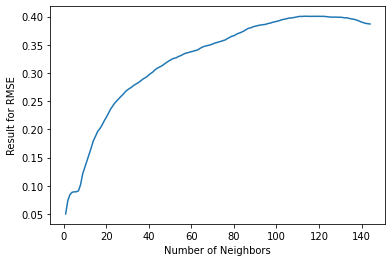

In [21]:
kn_plot(x_training, y_training, x_test, y_test, n=145)

Podemos utilizar o gráfico para ver que, para o conjunto de dados selecionado, o modelo de K-vizinhos possui uma maior acurácia com comparções utilizando apenas 1 vizinho como base.

# Árvore de decisões

O próximo modelo avaliado é o de árvore de decisão. Este modelo utiliza uma série de decisões para cada ponto a fim de classificá-lo, com isso, é possível obter um modelo capaz de encontrar possíveis padrões não visiveis de maneira simples.

Primeiramente, podemos criar um modelo simples com todos os hiperparâmetros padrões, de modo a entender o modelo

In [22]:
# cria o modelo
modelo_dt = DecisionTreeRegressor(random_state=seed)

# treina o modelo
modelo_dt.fit(x_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(x_teste)
print(previsao)

[[ 11.  11.]
 [ 12.  11.]
 [ 13.  12.]
 [ 27.  28.]
 [ 20.  20.]
 [ 24.  25.]
 [ 28.  27.]
 [ 17.  17.]
 [ 38.  38.]
 [ 28.  27.]
 [ 23.  23.]
 [  5.  -1.]
 [ 24.  23.]
 [ 19.  19.]
 [ 24.  26.]
 [ 25.  26.]
 [  4.  -1.]
 [ 21.  21.]
 [  5.   1.]
 [ 23.  23.]
 [-23. -36.]
 [ 22.  22.]
 [ 23.  25.]
 [ 38.  38.]
 [-23. -36.]
 [  4.  -1.]
 [ 21.  21.]
 [ 22.  22.]
 [-23. -36.]
 [ 22.  22.]
 [ 27.  25.]
 [ 27.  29.]
 [ 26.  28.]
 [ 31.  30.]
 [ 24.  23.]
 [ 22.  22.]
 [ 19.  19.]]


Com o modelo construido e sua previsão feita para os valores, podemos ver o RMSE do modelo.

In [23]:
RMSE = mean_squared_error(y_teste, previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE}.")

O RMSE do modelo árvore de decisão foi de 1.8372051742268887.


Podemos ver que mesmo sem fazer alterações, o modelo em geral teve uma performance muito boa, principalmente considerando o modelo baseline e o modelo linear.

Agora, vamos ver a árvore no seu modo mais literal, plotando um gráfico que mostra o caminho percorrido pelos valores na árvores.

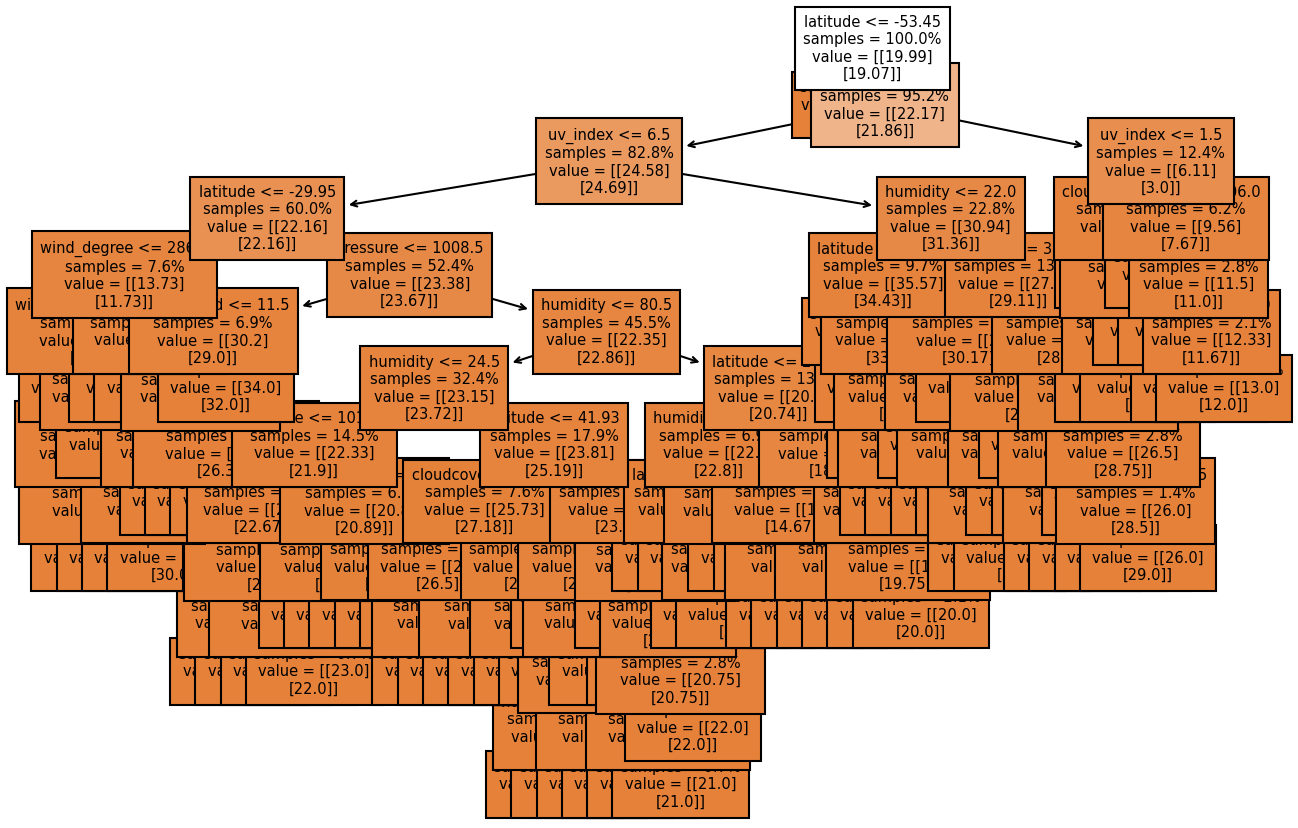

In [24]:
# cria e treina o modelo
modelo_dt = DecisionTreeRegressor(random_state=seed)
modelo_dt.fit(x_treino, y_treino)

# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(10, 7),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=FEATURES,
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
    fontsize=7,
)

# mostra o plot para o usuário
plt.show()

Apesar de grande e cheio, podemos ver que oque leva a árvore a ter seu RMSE, uma série de decisões feitas por ela, levam a um valor final para temperatura.

Podemos ver a árvore também em seu modo de texto

In [25]:
texto_dt = export_text(
    modelo_dt,
    feature_names=FEATURES,
    decimals=2,
)

print(texto_dt)

|--- latitude <= -53.45
|   |--- value: [-23.00, -36.00]
|--- latitude >  -53.45
|   |--- latitude <= 67.95
|   |   |--- uv_index <= 6.50
|   |   |   |--- latitude <= -29.95
|   |   |   |   |--- wind_degree <= 286.00
|   |   |   |   |   |--- wind_degree <= 238.50
|   |   |   |   |   |   |--- value: [17.00, 17.00]
|   |   |   |   |   |--- wind_degree >  238.50
|   |   |   |   |   |   |--- latitude <= -32.50
|   |   |   |   |   |   |   |--- wind_speed <= 20.00
|   |   |   |   |   |   |   |   |--- value: [14.00, 14.00]
|   |   |   |   |   |   |   |--- wind_speed >  20.00
|   |   |   |   |   |   |   |   |--- wind_degree <= 268.00
|   |   |   |   |   |   |   |   |   |--- value: [15.00, 12.00]
|   |   |   |   |   |   |   |   |--- wind_degree >  268.00
|   |   |   |   |   |   |   |   |   |--- value: [14.00, 12.00]
|   |   |   |   |   |   |--- latitude >  -32.50
|   |   |   |   |   |   |   |--- value: [12.00, 11.00]
|   |   |   |   |--- wind_degree >  286.00
|   |   |   |   |   |--- cloudcover

Apesar de dificl de interpretar, podemos ver exatamente as decisões tomadas pela árvore até chegar a um resultado

Finalmente, podemos alterar alguns de seus hiperparâmetros buscando o melhor modelo

In [26]:
lista_valores = list(range(5,50+1))
lista_valores.append(None)

b_RMSE = {
    'rmse': 10000,
    'n_folhas': 'inicial',
    'n_prof': 'inicial'
}

for n_folhas, n_profundidade in product(lista_valores, lista_valores):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=seed,
    )

    modelo_dt.fit(x_training, y_training)

    y_prev = modelo_dt.predict(x_test)
    RMSE = mean_squared_error(y_test, y_prev, squared=False)
    
    if RMSE < b_RMSE['rmse']:
        b_RMSE['rmse'] = RMSE
        b_RMSE['n_folhas'] = n_folhas
        b_RMSE['n_prof'] = n_profundidade
                
print(
    f"O RMSE do modelo AD usando max_leaf_nodes={b_RMSE['n_folhas']}"
    f"e max_depth={b_RMSE['n_prof']} foi de {b_RMSE['rmse']:f}."
)

O RMSE do modelo AD usando max_leaf_nodes=13e max_depth=9 foi de 0.048547.


O melhor resultado obtido pela busca foi um RMSE de 0.048 °C, ou seja, uma precisão muito boa, acima de qualquer outra encontrada

# Floresta aleatória.

O próximo modelo é o de floresta aleatória. Este modelo utiliza um conjunto de àrvores diferentes para fazer sua previsão. Primeiramente, precisamos, novamente, dividir os dados em treino e teste, porém, desta vez, utilizaremos os valores brutos dos dados, sem modifica-los.

In [27]:
feat_treino, feat_teste = train_test_split(df[FEATURES], test_size=test_size, random_state=seed)
temp_treino, temp_teste = train_test_split(df["temperature"], test_size=test_size, random_state=seed)
feel_treino, feel_teste = train_test_split(df["feelslike"], test_size=test_size, random_state=seed)

Com isso, podemos criar modelos simples apenas para ter uma ideia

In [28]:
temp_treino = temp_treino.ravel()
temp_teste = temp_teste.ravel()

modelo_rf_temp = RFR(random_state=seed)
modelo_rf_feel = RFR(random_state=seed)

modelo_rf_temp.fit(feat_treino, temp_treino)
modelo_rf_feel.fit(feat_treino, feel_treino)

previsao_temp = modelo_rf_temp.predict(feat_teste)
previsao_feel = modelo_rf_feel.predict(feat_teste)
print(previsao_temp)
print(previsao_feel)

[ 0.28842105  0.35763158  0.32526316  0.71763158  0.52157895  0.62789474
  0.77052632  0.38657895  0.98315789  0.76973684  0.60473684  0.17289474
  0.64342105  0.52368421  0.58763158  0.59789474  0.12526316  0.56026316
  0.12342105  0.61210526 -0.60526316  0.57657895  0.60578947  0.98315789
 -0.60526316  0.12052632  0.55763158  0.57473684 -0.60526316  0.58842105
  0.72447368  0.68842105  0.66921053  0.75763158  0.63736842  0.56894737
  0.53026316]
[ 0.26868421  0.39552632  0.27236842  0.72447368  0.51026316  0.65473684
  0.70657895  0.35447368  0.98315789  0.7         0.60026316  0.06131579
  0.64736842  0.52394737  0.63026316  0.63052632  0.01026316  0.59105263
  0.01710526  0.605      -0.94736842  0.58684211  0.64184211  0.98315789
 -0.94736842  0.01        0.55894737  0.57710526 -0.94736842  0.62157895
  0.70947368  0.74026316  0.715       0.75368421  0.64578947  0.60973684
  0.56868421]


Tendo como resultado as previsões acima, porém o quão bom são elas?

In [29]:
RMSE_temp = mean_squared_error(temp_teste, previsao_temp, squared=False)
RMSE_feel = mean_squared_error(feel_teste, previsao_feel, squared=False)

print(f'RMSE temperature: {RMSE_temp}\nRMSE Feelslike: {RMSE_feel}')

RMSE temperature: 0.041096991570902026
RMSE Feelslike: 0.04614429000956279


c:\venv\ilumpy\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
c:\venv\ilumpy\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Inrcivelmente, as previsões feitas pela floresta tem uma acurácia muito boa, estando dentre as melhores obtidas

Podemos então mudar todos os hiperparâmetros buscando novamente a melhor combinação

In [30]:
def rf(leafs, depth, trees):
    from itertools import product

    RMSEs = []
    
    for l, d, t in product(leafs, depth, trees):
        modelo_rf_temp = RFR(n_estimators=t, max_leaf_nodes=l, max_depth=d, random_state=seed, n_jobs=4)
        modelo_rf_feel = RFR(n_estimators=t, max_leaf_nodes=l, max_depth=d, random_state=seed, n_jobs=4)

        modelo_rf_temp.fit(feat_treino, temp_treino)
        modelo_rf_feel.fit(feat_treino, feel_treino)
        
        p_temp = modelo_rf_temp.predict(feat_teste)
        p_feel = modelo_rf_feel.predict(feat_teste)
        
        RMSE_temp = mean_squared_error(temp_teste, p_temp, squared=False)
        RMSE_feel = mean_squared_error(feel_teste, p_feel, squared=False)
        
        RMSEs.append([l, d, t, RMSE_temp, RMSE_feel])
        
        #print(f'Leafs={l}\t\tDepth={d}\t\tTrees={t}\t\tRMSE temperature={RMSE_temp}\t\tRMSE feelslike={RMSE_feel}')
        
    return RMSEs

Feita a função, basta roda-la para obter um resultado

In [31]:
%%capture --no-display

folhas = [None, 6]
profundidade = [None, 3]
arvores = [10, 100, 300]

RMSEs = rf(folhas, profundidade, arvores)

In [32]:
RMSEs

[[None, None, 10, 0.038054133706621314, 0.045703308343067836],
 [None, None, 100, 0.04109699157090202, 0.04614429000956278],
 [None, None, 300, 0.042820555150928696, 0.047198904657489785],
 [None, 3, 10, 0.07532905629834699, 0.0951624251879802],
 [None, 3, 100, 0.07712677757641162, 0.09402500103572449],
 [None, 3, 300, 0.077142223232582, 0.09422964671433406],
 [6, None, 10, 0.06192491511863396, 0.08653963395044485],
 [6, None, 100, 0.06149050717515304, 0.08242388013349197],
 [6, None, 300, 0.06214181535398773, 0.08192489705070827],
 [6, 3, 10, 0.07532905629834696, 0.0951624251879802],
 [6, 3, 100, 0.07710306796509461, 0.09404024033695954],
 [6, 3, 300, 0.07714900400055533, 0.09422519004835499]]

Este nos mostra que os melhores modelos são mais simples doque esperado, mas chegando a uma acurácia de 0.038 °C para a temperatura e 0.045 °C para o feelslike

### Mudando os Hiperparâmetros separadamente.

Podemos também mudar os hiperparâmetros de maneira separada, com o intuito de plotar gráficos comparativos

In [33]:
folhas = [None]
for i in range(2, 100):
    folhas.append(i)

profundidade = [None]
for i in range(1, 100):
    profundidade.append(i)

arvores = [i for i in range(1, 100)]

In [34]:
%%capture --no-display

RMSEs_temp = []
RMSEs_feel = []
for i in folhas:
    model_temp = RFR(max_leaf_nodes=i, random_state=seed, n_jobs=4)
    model_feel= RFR(max_leaf_nodes=i, random_state=seed, n_jobs=4)
    
    model_temp.fit(feat_treino, temp_treino)
    model_feel.fit(feat_treino, feel_treino)
    
    prev_temp = model_temp.predict(feat_teste)
    prev_feel = model_feel.predict(feat_teste)
    
    RMSE_temp = mean_squared_error(temp_teste, prev_temp, squared=False)
    RMSE_feel = mean_squared_error(feel_teste, prev_feel, squared=False)
    
    RMSEs_temp.append(RMSE_temp)
    RMSEs_feel.append(RMSE_feel)

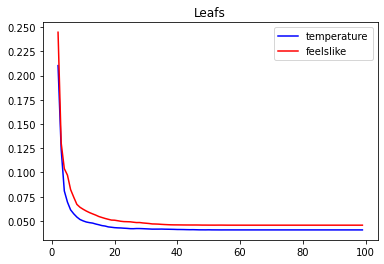

Leafs:
Temperature RMSE:0.04079623323975885, Index:53, Value:54
Feelslike RMSE:0.04568002985694747, Index:62, Value:63


In [35]:
fig, axe = plt.subplots()
axe.plot(folhas, RMSEs_temp, color='b', label='temperature')
axe.plot(folhas, RMSEs_feel, color='r', label='feelslike')
axe.legend(loc='upper right')
axe.title.set_text('Leafs')
plt.show()

index_temp = RMSEs_temp.index(min(RMSEs_temp))
index_feel = RMSEs_feel.index(min(RMSEs_feel))

print('Leafs:')
print(f'Temperature RMSE:{min(RMSEs_temp)}, Index:{index_temp}, Value:{folhas[index_temp]}')
print(f'Feelslike RMSE:{min(RMSEs_feel)}, Index:{index_feel}, Value:{folhas[index_feel]}')

Deste modo, podemos ver comparativamente que o melhor modelo usou 64 folhas em temperatura e 63 em feelslike.

In [38]:
%%capture --no-display

RMSEs_temp = []
RMSEs_feel = []
for i in profundidade:
    model_temp = RFR(max_depth=i, random_state=seed, n_jobs=4)
    model_feel= RFR(max_depth=i, random_state=seed, n_jobs=4)
    
    model_temp.fit(feat_treino, temp_treino)
    model_feel.fit(feat_treino, feel_treino)
    
    prev_temp = model_temp.predict(feat_teste)
    prev_feel = model_feel.predict(feat_teste)
    
    RMSE_temp = mean_squared_error(temp_teste, prev_temp, squared=False)
    RMSE_feel = mean_squared_error(feel_teste, prev_feel, squared=False)
    
    RMSEs_temp.append(RMSE_temp)
    RMSEs_feel.append(RMSE_feel)

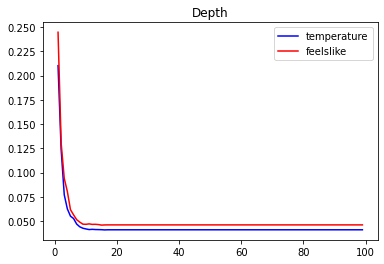

Depth:
Temperature RMSE:0.04096171704448888, Index:16, Value:17
Feelslike RMSE:0.045913982417718734, Index:15, Value:16


In [39]:
fig, axe = plt.subplots()
axe.plot(profundidade, RMSEs_temp, color='b', label='temperature')
axe.plot(profundidade, RMSEs_feel, color='r', label='feelslike')
axe.legend(loc='upper right')
axe.title.set_text('Depth')
plt.show()

index_temp = RMSEs_temp.index(min(RMSEs_temp))
index_feel = RMSEs_feel.index(min(RMSEs_feel))

print('Depth:')
print(f'Temperature RMSE:{min(RMSEs_temp)}, Index:{index_temp}, Value:{folhas[index_temp]}')
print(f'Feelslike RMSE:{min(RMSEs_feel)}, Index:{index_feel}, Value:{folhas[index_feel]}')

Neste caso, o melhor modelo de temperatura teve uma profundidade de 17 e o melhor de feelslike teve uma de 16

In [40]:
%%capture --no-display

RMSEs_temp = []
RMSEs_feel = []
for i in arvores:
    model_temp = RFR(n_estimators=i, random_state=seed, n_jobs=4)
    model_feel= RFR(n_estimators=i, random_state=seed, n_jobs=4)
    
    model_temp.fit(feat_treino, temp_treino)
    model_feel.fit(feat_treino, feel_treino)
    
    prev_temp = model_temp.predict(feat_teste)
    prev_feel = model_feel.predict(feat_teste)
    
    RMSE_temp = mean_squared_error(temp_teste, prev_temp, squared=False)
    RMSE_feel = mean_squared_error(feel_teste, prev_feel, squared=False)
    
    RMSEs_temp.append(RMSE_temp)
    RMSEs_feel.append(RMSE_feel)

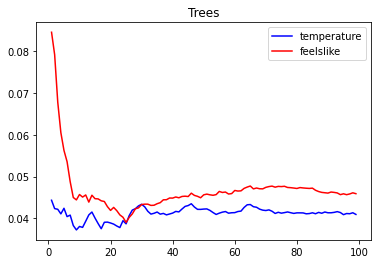

Trees:
Temperature RMSE:0.03722856210715128, Index:8, Value:9
Feelslike RMSE:0.039025334288491594, Index:24, Value:25


In [41]:
fig, axe = plt.subplots()
axe.plot(arvores, RMSEs_temp, color='b', label='temperature')
axe.plot(arvores, RMSEs_feel, color='r', label='feelslike')
axe.legend(loc='upper right')
axe.title.set_text('Trees')
plt.show()

index_temp = RMSEs_temp.index(min(RMSEs_temp))
index_feel = RMSEs_feel.index(min(RMSEs_feel))

print('Trees:')
print(f'Temperature RMSE:{min(RMSEs_temp)}, Index:{index_temp}, Value:{folhas[index_temp]}')
print(f'Feelslike RMSE:{min(RMSEs_feel)}, Index:{index_feel}, Value:{folhas[index_feel]}')

Por último, o melhor modelo de temperatura teve um número de 9 árvores e para feelslike esse número foi de 25

## Melhores modelos

E se juntarmos os melhores resultados separados?

In [43]:
best_model_temp = RFR(max_leaf_nodes=54, max_depth=16, n_estimators=9, random_state=seed, n_jobs=4)
best_model_feel = RFR(max_leaf_nodes=None, max_depth=17, n_estimators=25, random_state=seed, n_jobs=4)

best_model_temp.fit(feat_treino, temp_treino)
best_model_feel.fit(feat_treino, feel_treino)

prev_temp = best_model_temp.predict(feat_teste)
prev_feel = best_model_feel.predict(feat_teste)

print(mean_squared_error(temp_teste, prev_temp, squared=False))
print(mean_squared_error(feel_teste, prev_feel, squared=False))

0.04129255796288015
0.039025334288491594


c:\venv\ilumpy\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
c:\venv\ilumpy\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Apesar de ser uma ideia interessante ela retorna um resultado não muito bom, sendo estes modelos piores do que os previstos de maneira conjunta

## Importância.

A importância é uma forma de medir o quanto uma feature é utilizada para determinar o target desejado, deste modo, podemos ver quais features tem maior peso ou `importância` dentro do modelo

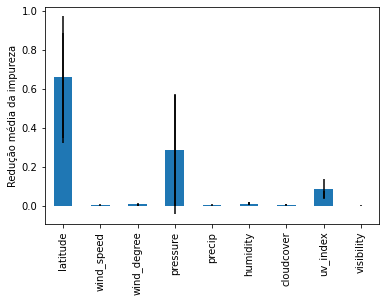

In [45]:
importancia_temp = best_model_temp.feature_importances_
importancia_feel = best_model_feel.feature_importances_

desvio_padrao_temp = np.std([arvore.feature_importances_ for arvore in best_model_temp.estimators_], axis=0)
desvio_padrao_feel = np.std([arvore.feature_importances_ for arvore in best_model_feel.estimators_], axis=0)

serie_importancia_temp = pd.Series(importancia_temp, index=FEATURES)
serie_importancia_feel = pd.Series(importancia_feel, index=FEATURES)

fig, axe = plt.subplots()

serie_importancia_temp.plot.bar(yerr=desvio_padrao_temp, ax=axe)
serie_importancia_feel.plot.bar(yerr=desvio_padrao_feel, ax=axe)

axe.set_ylabel("Redução média da impureza")
plt.show()

Como podemos ver, as 3 features mais importântes são a latitude, pressão e indice de UV. As outras também tem sua significância, mas possuem mudança muito menor do que comparadas com essas 3

In [52]:
N_REPETICOES = 10

def R2_1param(modelo, x, y):
    """Computa o coef. de determinação quando hip. alt. não tem coef. linear."""
    y_pred = modelo.predict(x).ravel()
    y_true = (np.array(y)).ravel()
    return 1 - sum((y_true - y_pred) ** 2) / sum(y_true**2)


X_local = feat_treino
y_local_temp = temp_treino
y_local_feel = feel_treino

R2_temp = R2_1param(best_model_temp, X_local, y_local_temp)
print(f"O R^2 da previsão temperature é de {R2_temp}\n")

r_temp = permutation_importance(
    best_model_temp,
    X_local,
    y_local_temp,
    n_repeats=N_REPETICOES,
    random_state=seed,
    scoring=R2_1param,
)

for i in r_temp.importances_mean.argsort()[::-1]:
    if r_temp.importances_mean[i] - 2 * r_temp.importances_std[i] > 0:
        print(f"{FEATURES[i]:<8} "
              f"{r_temp.importances_mean[i]:.3f}"
              f" +/- {r_temp.importances_std[i]:.3f}")
        
print('\n\n\n')

R2_feel = R2_1param(best_model_feel, X_local, y_local_feel)
print(f"O R^2 da previsão feelslike é de {R2_feel}\n")

r_feel = permutation_importance(
    best_model_feel,
    X_local,
    y_local_feel,
    n_repeats=N_REPETICOES,
    random_state=seed,
    scoring=R2_1param,
)

for i in r_feel.importances_mean.argsort()[::-1]:
    if r_feel.importances_mean[i] - 2 * r_feel.importances_std[i] > 0:
        print(f"{FEATURES[i]:<8} "
              f"{r_feel.importances_mean[i]:.3f}"
              f" +/- {r_feel.importances_std[i]:.3f}")

O R^2 da previsão temperature é de 0.999063780036528

latitude 0.270 +/- 0.018
pressure 0.076 +/- 0.007
uv_index 0.026 +/- 0.004
humidity 0.003 +/- 0.000
precip   0.001 +/- 0.000
wind_degree 0.001 +/- 0.000
cloudcover 0.001 +/- 0.000
wind_speed 0.000 +/- 0.000
visibility 0.000 +/- 0.000




O R^2 da previsão feelslike é de 0.9984666127064832

latitude 0.400 +/- 0.028
pressure 0.081 +/- 0.006
uv_index 0.031 +/- 0.004
humidity 0.004 +/- 0.001
wind_degree 0.001 +/- 0.000
precip   0.001 +/- 0.000
cloudcover 0.001 +/- 0.000
wind_speed 0.000 +/- 0.000
visibility 0.000 +/- 0.000


Aqui tambem podemos visualizar o impacto de cada feature no resultado do target, possuindo uma variâção positiva e negativa e se tornando muito pequena para as features menos importântes

# Classificação

O último caso a ser estudado é a classificação. Este consiste em separa a target em conjuntos definidos de opções discretas que o modelo deve prever.

<AxesSubplot:>

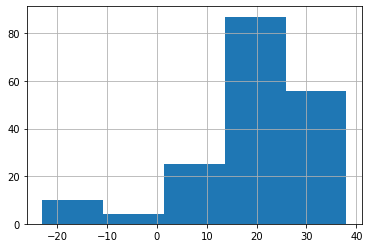

In [56]:
df_num["temperature"].hist(bins=5)

Podemos usar como base o histograma da temperatura para fazer a classificação desta grandeza

In [54]:
logic = df_num["temperature"] <= 5
print(len(df_num.loc[logic]),'Muito frio')
logic = (df_num["temperature"] > 5) & (df_num["temperature"] <= 16)
print(len(df_num.loc[logic]),'Frio')
logic = (df_num["temperature"] > 16) & (df_num["temperature"] <= 25)
print(len(df_num.loc[logic]),'Temperatura mediana')
logic = (df_num["temperature"] > 25) & (df_num["temperature"] <= 30)
print(len(df_num.loc[logic]),'Calor')
logic = (df_num["temperature"] > 30)
print(len(df_num.loc[logic]),'Muito calor')

23 Muito frio
26 Frio
77 Temperatura mediana
36 Calor
20 Muito calor


Obtendo esssas classificações dentro dos valores passados

In [57]:
df_num['Temp Categórica'] = None

logic = df_num["temperature"] <= 5
df_num.loc[logic, 'Temp Categórica'] = 'Muito frio'
logic = (df_num["temperature"] > 5) & (df_num["temperature"] <= 16)
df_num.loc[logic, 'Temp Categórica'] = 'Frio'
logic = (df_num["temperature"] > 16) & (df_num["temperature"] <= 25)
df_num.loc[logic, 'Temp Categórica'] = 'Temperatura mediana'
logic = (df_num["temperature"] > 25) & (df_num["temperature"] <= 30)
df_num.loc[logic, 'Temp Categórica'] = 'Calor'
logic = (df_num["temperature"] > 30)
df_num.loc[logic, 'Temp Categórica'] = 'Muito Calor'
df_num

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike,Temp Categórica
7,84.94,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
8,84.22,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
9,83.49,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
10,82.77,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
11,82.05,28,109,1013,0.0,80,37,1,10,5,1,Muito frio
...,...,...,...,...,...,...,...,...,...,...,...,...
224,-71.9,30,121,1002,0.0,60,46,1,10,-23,-36,Muito frio
225,-72.6,30,121,1002,0.0,60,46,1,10,-23,-36,Muito frio
226,-73.3,30,121,1002,0.0,60,46,1,10,-23,-36,Muito frio
227,-74.1,30,121,1002,0.0,60,46,1,10,-23,-36,Muito frio


Com um DataFrame dessas classificações em mãos, podemos utiliza-lo para o modelo

In [58]:
TARGET = ["Temp Categórica"]

indices = df_num.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=test_size, random_state=seed
)

df_treino = df_num.loc[indices_treino]
df_teste = df_num.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

Com o modelo treinado

In [60]:
modelo_dt = DecisionTreeClassifier(random_state=seed)

modelo_dt.fit(X_treino, y_treino)

previsao = modelo_dt.predict(X_teste)
print(previsao)

['Frio' 'Temperatura mediana' 'Frio' 'Calor' 'Temperatura mediana'
 'Temperatura mediana' 'Calor' 'Frio' 'Muito Calor' 'Calor'
 'Temperatura mediana' 'Muito frio' 'Temperatura mediana'
 'Temperatura mediana' 'Temperatura mediana' 'Temperatura mediana'
 'Muito frio' 'Temperatura mediana' 'Muito frio' 'Temperatura mediana'
 'Muito frio' 'Temperatura mediana' 'Temperatura mediana' 'Muito Calor'
 'Muito frio' 'Muito frio' 'Temperatura mediana' 'Temperatura mediana'
 'Muito frio' 'Temperatura mediana' 'Muito Calor' 'Calor' 'Calor'
 'Muito Calor' 'Temperatura mediana' 'Temperatura mediana'
 'Temperatura mediana']


Chegamos a essas previsões para o modelo

Mas o quão bom elas são?

___

In [61]:
from sklearn import metrics

In [62]:
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))
print("Precisão (micro):",metrics.precision_score(y_teste, previsao, average='micro'))
print("Precisão (macro):",metrics.precision_score(y_teste, previsao, average='macro'))
print("Precisão (weighted):",metrics.precision_score(y_teste, previsao, average='weighted'))

Accuracy: 0.918918918918919
Precisão (micro): 0.918918918918919
Precisão (macro): 0.888888888888889
Precisão (weighted): 0.9474474474474475


Podemos ver uma acurácia de 91% do modelo, oque é um valor alto, principalmente considerando a natureza caotica dos dados

___

Fazendo uma procura pelos melhores parâmetros

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10,12,14,16],
    'criterion' :['gini', 'entropy'],
    'max_leaf_nodes': [5,10,15,20,25,30,35,36,37,38,39,40,45,50]
}
CV_rfc = GridSearchCV(estimator=modelo_dt, param_grid=param_grid, cv= 5, n_jobs=8)
CV_rfc.fit(X_treino, y_treino)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=97404),
             n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14, 16],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 36, 37,
                                            38, 39, 40, 45, 50]})

Pegando os melhores parâmetros

In [65]:
print(CV_rfc.best_params_)
best_params = CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 25}


Fazendo o modelo com melhores parâmetros

In [69]:
modelo_dt = DecisionTreeClassifier(random_state=seed)
modelo_dt.set_params(**best_params)

DecisionTreeClassifier(max_depth=10, max_features='auto', max_leaf_nodes=25,
                       random_state=97404)

In [67]:
modelo_dt.fit(X_treino, y_treino)
previsao = modelo_dt.predict(X_teste)
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))
print("Precisão (micro):",metrics.precision_score(y_teste, previsao, average='micro'))
print("Precisão (macro):",metrics.precision_score(y_teste, previsao, average='macro'))
print("Precisão (weighted):",metrics.precision_score(y_teste, previsao, average='weighted'))

Accuracy: 0.918918918918919
Precisão (micro): 0.918918918918919
Precisão (macro): 0.9492063492063492
Precisão (weighted): 0.921921921921922


Chegando a uma acurácia de 91.8%, uma mudança muito pequena, mas ainda assim é uma melhora com relação ao anterior

In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_teste, previsao)

array([[ 6,  0,  0,  0,  1],
       [ 0,  3,  0,  0,  1],
       [ 0,  0,  2,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 1,  0,  0,  0, 16]], dtype=int64)

O último resultado a ser tirado é a matrix de confusão, que mostra onde o modelo classificou erroneamente os valores